<a href="https://colab.research.google.com/github/BenYavor/Comparison_of_communication_Autoencoder_MI_GAN_WGAN/blob/master/Compaire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.0.0
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt   
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import tensorflow as tf
import os
tf.__version__
from tensorflow import keras
import time
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import sys
assert sys.version_info >= (3, 5)
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from scipy import special
#from Clustering_Equalgrps.equal_groups import EqualGroupsKMeans
from tensorflow.keras import layers
np.random.seed(42)
tf.random.set_seed(42)

#### Vergleich
Als erstes für feste $k$ und $n$, was sich ändert ist die Samplesize, Anzahl der Samples und SNR

###Systemparameter
ACHTUNG: CHANNELANZAHL WURDE UNTERSCHIEDLICH VERWENDET \\
$k$ - die Anzhal der bits \\
$M$ - Anzahl der unterschiedlichen Nachrichten \\
$n$ - channel uses\\
$N$ - Länge des Rauschvektors

In [2]:
k = 4      # Number of information bits per message, i.e., M=2**k
M = 2**k
n = 2    # Number of real channel uses per message
#k = int(np.log2(M))
#n = 2
print(M)

SNR = 7


16


## Training Parameter

In [0]:
gen_learning_rate=0.0001 
disc_learning_rate = 0.0005                  # 0.0001  

### Different Layers

In [0]:
randN_initial = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

EncIn = tf.keras.layers.Input(shape=(M,))#, dtype= tf.int32)
e1 = tf.keras.layers.Dense(2*n, activation=None)
e2 = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,int(n/2),2]))
EncOut = tf.keras.layers.Lambda(lambda x: x/tf.sqrt(2*tf.reduce_mean(tf.square(x))))
GenIn = tf.keras.layers.Lambda(lambda x:tf.reshape(x,(tf.shape(x)[0],-1)))
# = tf.keras.layers.Lambda(generator)
DecIn = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,int(n/2),2]))
d1 = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,n]))
d2 = tf.keras.layers.Dense(M, activation='relu')
DecOut = tf.keras.layers.Dense(M, activation='softmax')


#noise_std = EbNo_to_noise(TRAINING_SNR)
# custom functions / layers without weights
norm_layer = keras.layers.Lambda(lambda x: tf.divide(x,tf.sqrt(2*tf.reduce_mean(tf.square(x)))))
shape_layer = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,2,n]))
shape_layer2 = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,n]))
channel_layer = keras.layers.Lambda(lambda x: x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std))

### Help functions

In [5]:
def EbNo2Sigma(ebnodb):
    '''Convert Eb/No in dB to noise standard deviation'''
    ebno = 10**(ebnodb/10)
    return 1/np.sqrt(2*(2*k/n)*ebno)

def EbNo_to_noise(ebnodb):
    '''Transform EbNo[dB]/snr to noise power'''
    ebno = 10**(ebnodb/10)
    noise_std = 1/np.sqrt(2*(2*k/n)*ebno) 
    return noise_std


def real_channel(x,noise_std):
    # Black-box Channel
    #AWGN
    return x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)

    #Rayleigh
    #return x + tf.sqrt(tf.square(tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std)) + tf.square(tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std)))
    
    #Uniform U(-3;3)    
    #return x + tf.random_uniform(tf.shape(x), minval=-2, maxval=2)

def B_Ber(input_msg, msg):
    '''Calculate the Batch Bit Error Rate'''
    pred_error = tf.not_equal(tf.argmax(msg, 1), tf.argmax(input_msg, 1))
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

def random_sample(batch_size=32):
    msg = np.random.randint(M, size=batch_size)
    return msg




def B_Ber_m(input_msg, msg):
    '''Calculate the Batch Bit Error Rate'''
    pred_error = tf.not_equal(input_msg, tf.argmax(msg, 1))      
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

def SNR_to_noise(snrdb):
    '''Transform EbNo[dB]/snr to noise power'''
    snr = 10**(snrdb/10)
    noise_std = 1/np.sqrt(2*snr)
    return noise_std

noise_std = EbNo2Sigma(SNR)

print(EbNo2Sigma(SNR))
print(EbNo_to_noise(SNR))

0.15792649852735607
0.15792649852735607


In [0]:
def test_encoding(M=16, n=1):
    inp = np.arange(0,M)
    coding = gan_encoder.predict(inp)
    fig = plt.figure(figsize=(4,4))
    plt.plot(coding[:,0], coding[:, 1], "b.")
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()

def test_w_encoding(M=16, n=1):
    inp = np.arange(0,M)
    coding = w_gan_encoder.predict(inp)
    fig = plt.figure(figsize=(4,4))
    plt.plot(coding[:,0], coding[:, 1], "b.")
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()

def test_noisy_codeword(data):
    rcvd_word = data[1:2000]
    fig = plt.figure(figsize=(4,4))
    plt.plot(rcvd_word[:,0], rcvd_word[:, 1], "b.")
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()

# Models

#### Generator Model

In [0]:
def get_generator(n):
  input1 = tf.keras.layers.Input(shape=(n,))
  x1 = tf.keras.layers.Dense(n)(input1)
  input2 =tf.random.normal(shape=tf.shape(input1))
  #input2 =tf.random.normal([tf.shape(input1)[0],n])
  x2 = tf.keras.layers.Dense(n)(input2)
  subtracted = tf.keras.layers.Concatenate(1)([x1, x2])
  h1 = tf.keras.layers.Dense(32,use_bias=True,  activation='relu')(subtracted)
  h2 = tf.keras.layers.Dense(32,use_bias=True, activation='relu')(h1)
  out = tf.keras.layers.Dense(n, use_bias= True, activation='linear')(h2)
  generator = tf.keras.models.Model(inputs=[input1], outputs=out)
  return generator

def get_w_generator(n):
  inputx1 = tf.keras.layers.Input(shape=(n,))
  x1 = tf.keras.layers.Dense(n)(inputx1)
  inputx2 =tf.random.normal(shape=tf.shape(inputx1))
  x2 = tf.keras.layers.Dense(n)(inputx2)
  subtracted = tf.keras.layers.Concatenate(1)([x1, x2])
  h1 = tf.keras.layers.Dense(32,use_bias=True,  activation='relu')(subtracted)
  h2 = tf.keras.layers.Dense(32,use_bias=True, activation='relu')(h1)
  out = tf.keras.layers.Dense(n, use_bias= True, activation='linear')(h2)
  generator = tf.keras.models.Model(inputs=[inputx1], outputs=out)
  return generator
#keras.utils.plot_model(generator, 'Structure_of_MI_estimation.png', show_shapes=True)


#### Discriminator Model 

In [0]:
def get_discriminator(n):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(32,use_bias=True, kernel_initializer=randN_initial,activation='relu',input_shape=((2*n,))))
  #model.add(tf.keras.layers.Dense(32,use_bias=True, kernel_initializer=randN_initial, activation='relu'))
  model.add(tf.keras.layers.Dense(1,use_bias=False, activation='sigmoid'))
  return model


In [0]:
w_generator = get_w_generator(n)
w_discriminator = get_discriminator(n)
generator = get_generator(n)
discriminator = get_discriminator(n)

#### Encoder GAN Model

In [0]:
def get_gan_encoder(M):
  model = keras.models.Sequential([
            keras.layers.Embedding(M, M, embeddings_initializer='glorot_normal'),
            keras.layers.Dense(M, activation="elu"),
            keras.layers.Dense(n, activation=None),
            e2,
            EncOut,
            GenIn])
  return model


#### decoder GAN Model

In [0]:
def get_gan_decoder(M):
   model= keras.models.Sequential([
                #DecIn,
                #d1,
                keras.layers.Dense(M, activation="elu"),
                keras.layers.Dense(M, activation="softmax")
                ])
   return model

### MI estimator Model

In [0]:
randN_05 = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
bias_init = keras.initializers.Constant(0.01)

input_A = keras.layers.Input(shape=[2*n])
input_B = keras.layers.Input(shape=[2*n])
    
transform = keras.models.Sequential([
layers.Dense(256, bias_initializer=bias_init, kernel_initializer=randN_05, activation="relu"),
#keras.layers.Dropout(rate=0.3), # To regularize higher dimensionality
layers.Dense(256, bias_initializer=bias_init, kernel_initializer=randN_05, activation="relu"),
#keras.layers.Dropout(rate=0.3), # To regularize higher dimensionality
layers.Dense(1, bias_initializer=bias_init, kernel_initializer=randN_05, activation=None)])

output_A = transform(input_A)
output_B = transform(input_B)
output_C = tf.reduce_mean(output_A) - tf.math.log(tf.reduce_mean(tf.exp(output_B))) # MINE
MI_mod = keras.models.Model(inputs=[input_A, input_B], outputs=output_C)

#keras.utils.plot_model(MI_mod, 'Structure_of_MI_estimation.png', show_shapes=True)



In [0]:
mi_encoder = keras.models.Sequential([
            keras.layers.Embedding(M, M, embeddings_initializer='glorot_normal'),
            keras.layers.Dense(M, activation="elu"),
            keras.layers.Dense(n, activation=None),
            shape_layer,
            norm_layer])

mi_channel = keras.models.Sequential([channel_layer])

mi_decoder = keras.models.Sequential([
                keras.layers.InputLayer(input_shape=[2,int(n/2)]),
                shape_layer2,
                keras.layers.Dense(M, activation="elu"),
                keras.layers.Dense(M, activation="softmax")
                ])

autoencoder = keras.models.Sequential([mi_encoder, mi_channel, mi_decoder])

In [0]:
def gan_optimizers(gen_learning_rate  ,disc_learning_rate):
  generator_optimizer = tf.keras.optimizers.RMSprop(gen_learning_rate)      #RMSprop   in oreder to test where the error comes from
  discriminator_optimizer = tf.keras.optimizers.RMSprop(disc_learning_rate) 
  return generator_optimizer, discriminator_optimizer

In [0]:
def plot_loss(step, epoch, mean_loss, X_batch, y_pred, plot_encoding):
    template = 'Iteration: {}, Epoch: {}, Loss: {:.5f}, Batch_BER: {:.5f}'
    if step % 10 == 0:
        print(template.format(step, epoch, mean_loss.result(), B_Ber_m(X_batch, y_pred)))
        if plot_encoding:
            test_encoding()

In [0]:
def plot_batch_loss(epoch, mean_loss, X_batch, y_pred):
        template_outer_loop = 'Interim result for Epoch: {}, Loss: {:.5f}, Batch_BER: {:.5f}'
        print(template_outer_loop.format(epoch, mean_loss.result(), B_Ber_m(X_batch, y_pred)))

In [0]:
def split_train_data(x_sample, y_sample):
    x_shaped = tf.reshape(x_sample, shape=[-1,n])
    y_shaped = tf.reshape(y_sample, shape=[-1,n])
    x_sample1, x_sample2 = tf.split(x_shaped, num_or_size_splits=2)
    y_sample1, y_sample2 = tf.split(y_shaped, num_or_size_splits=2)
    joint_sample = tf.concat([x_sample1, y_sample1], axis=1)
    marg_sample = tf.concat([x_sample2, y_sample1], axis=1)
    return joint_sample, marg_sample

In [0]:

def train_mi(n_epochs=5, n_steps=20, batch_size=200, learning_rate=0.005):
    optimizer_mi = keras.optimizers.Nadam(lr=learning_rate)
    for epoch in range(1, n_epochs + 1): 
        print("Training in Epoch {}/{}".format(epoch, n_epochs)) 
        for step in range(1, n_steps + 1):
            X_batch = random_sample(batch_size*2)
            with tf.GradientTape() as tape:
                x_enc = mi_encoder(X_batch, training=True)
                y_recv = mi_channel(x_enc)
                joint_marg_s = split_train_data(x_enc, y_recv)
                loss = -MI_mod(joint_marg_s)
                gradients = tape.gradient(loss, MI_mod.trainable_variables) 
                optimizer_mi.apply_gradients(zip(gradients, MI_mod.trainable_variables))
            mi_avg = -mean_loss(loss)
        print('Epoch: {}, Mi is {}'.format(epoch, mi_avg))
        mean_loss.reset_states()

In [0]:

def train_decoder(n_epochs=5, n_steps=20, batch_size=200, learning_rate=0.005, plot_encoding=True):
    optimizer_ae = keras.optimizers.Nadam(lr=learning_rate)
    for epoch in range(1, n_epochs + 1): 
        print("Training Bob in Epoch {}/{}".format(epoch, n_epochs)) 
        for step in range(1, n_steps + 1):
            X_batch  = random_sample(batch_size)
            with tf.GradientTape() as tape:
                y_pred = autoencoder(X_batch, training=True)
                loss = tf.reduce_mean(loss_fn(X_batch, y_pred))
                gradients = tape.gradient(loss, mi_decoder.trainable_variables) 
                optimizer_ae.apply_gradients(zip(gradients, mi_decoder.trainable_variables)) 
            mean_loss(loss)
            plot_loss(step, epoch, mean_loss, X_batch, y_pred, plot_encoding)
        plot_batch_loss(epoch, mean_loss, X_batch, y_pred) 
        mean_loss.reset_states()

In [0]:

def train_encoder(n_epochs=5, n_steps=20, batch_size=200, learning_rate=0.05):
    optimizer_mi = keras.optimizers.Nadam(lr=0.005)
    optimizer_ae = keras.optimizers.Nadam(lr=learning_rate)
    for epoch in range(1, n_epochs + 1): 
        print("Training Bob in Epoch {}/{}".format(epoch, n_epochs)) 
        for step in range(1, n_steps + 1):
            X_batch  = random_sample(batch_size)
            with tf.GradientTape() as tape:
                x_enc = mi_encoder(X_batch, training=True)
                y_recv = mi_channel(x_enc)
                joint_marg_s = split_train_data(x_enc, y_recv)
                loss = -MI_mod(joint_marg_s)
                gradients = tape.gradient(loss, mi_encoder.trainable_variables) 
                optimizer_ae.apply_gradients(zip(gradients, mi_encoder.trainable_variables))
            mi_avg = -mean_loss(loss)
        with tf.GradientTape() as tape:
            X_batch  = random_sample(batch_size) 
            x_enc = mi_encoder(X_batch, training=True)
            y_recv = mi_channel(x_enc)
            joint_marg_s = split_train_data(x_enc, y_recv)
            loss = -MI_mod(joint_marg_s)
            gradients = tape.gradient(loss, MI_mod.trainable_variables) 
            optimizer_mi.apply_gradients(zip(gradients, MI_mod.trainable_variables))
        print('Epoch: {}, Mi is {}'.format(epoch, mi_avg))
       # test_encoding(M, 1)

In [21]:
%%time
def train_gan(epochs,n_steps, batch_size, SNR_level):
  noise_std = EbNo2Sigma(SNR_level)
  start = time.time()
  x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32) 
  x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
  counter = 0
  epoch = 0
  for epoch in range(epochs):
    counter += 1
    train_step(noise_std, n_steps,batch_size)
    if counter%100==0:
      tf.print("counter %d:" % (counter))
      fake_c = generator(x)
      tf.print(fake_c[0])
    #print ('Time for epoch {} is {} sec,'.format(epoch + 1, time.time()-start))
      tf.print ('Time for epoch {},'.format(epoch + 1))
      
  tf.saved_model.save(generator,'/tmp/saved_model/')
  tf.print ('Time for the training is {} sec,'.format( time.time()-start))
    

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


In [0]:
@tf.function
def train_step(noise_std,n_steps,batch_size):
  x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32) 
  x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
  for i in range(n_steps):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      real_training_data = tf.concat(values=[real_channel(x,noise_std), x], axis=1)
      fake_training_data = tf.concat(values=[generator(x),x], axis=1)
      real_output = discriminator(real_training_data)
      fake_output = discriminator(fake_training_data)
      
      
      disc_loss = -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output))
      gen_loss =-tf.reduce_mean(tf.math.log(fake_output))
      
      #tf.print(disc_loss,gen_loss)
      
      if tf.math.is_nan(disc_loss) == False:
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
      if i == 4:  
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))



In [0]:
def creating_and_train_gan(epochs,n_steps, batch_size, SNR_level , n ):  #optional Leraning Rates
  train_gan(epochs, n_steps, batch_size, SNR_level)
  #4 after GAN training
  generator.trainable = False
  tf.print(generator.trainable)

In [0]:
def mi_Test_AE(data):
    '''Calculate Bit Error for varying SNRs'''
    snr_range = np.linspace(0, 15, 31)
    bber_vec = [None] * len(snr_range)
        
    for db in range(len(snr_range)):           
        noise_std = EbNo_to_noise(snr_range[db])
        code_word = mi_encoder(data)
        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std)
        dcoded_msg = mi_decoder(rcvd_word)
        bber_vec[db] = B_Ber_m(data, dcoded_msg)
        if (db % 6 == 0) & (db > 0):
            print(f'Progress: {db} of {30} parts')

    return (snr_range, bber_vec)


def gan_Test_AE(data):
    '''Calculate Bit Error for varying SNRs'''
    snr_range = np.linspace(0, 15, 31)
    bber_vec = [None] * len(snr_range)
        
    for db in range(len(snr_range)):           
        noise_std = EbNo_to_noise(snr_range[db])
        code_word = gan_encoder(data)
        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std)
        dcoded_msg = gan_decoder(rcvd_word)
        bber_vec[db] = B_Ber_m(data, dcoded_msg)
        if (db % 6 == 0) & (db > 0):
            print(f'Progress: {db} of {30} parts')

    return (snr_range, bber_vec)

def w_gan_Test_AE(data):
    '''Calculate Bit Error for varying SNRs'''
    snr_range = np.linspace(0, 15, 31)
    bber_vec = [None] * len(snr_range)
        
    for db in range(len(snr_range)):           
        noise_std = EbNo_to_noise(snr_range[db])
        code_word = w_gan_encoder(data)
        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std)
        dcoded_msg = w_gan_decoder(rcvd_word)
        bber_vec[db] = B_Ber_m(data, dcoded_msg)
        if (db % 6 == 0) & (db > 0):
            print(f'Progress: {db} of {30} parts')

    return (snr_range, bber_vec)


# GAN Training

In [25]:
%%time

generator_optimizer, discriminator_optimizer = gan_optimizers(gen_learning_rate=gen_learning_rate, disc_learning_rate = disc_learning_rate)
start = time.time()
creating_and_train_gan(epochs= 5000,n_steps=5, batch_size =100, SNR_level = 7, n = n)
time_to_train_gan = time.time()-start
tf.print ('Time for the training is {} sec,'.format( time.time()-start))

counter 100:
[-0.0317160524 0.130993053]
Time for epoch 100,
counter 200:
[0.0115681309 0.349815577]
Time for epoch 200,
counter 300:
[-0.0318347849 0.183775589]
Time for epoch 300,
counter 400:
[-0.00576118752 0.288710415]
Time for epoch 400,
counter 500:
[-0.840965748 0.669303536]
Time for epoch 500,
counter 600:
[0.251199901 0.595262408]
Time for epoch 600,
counter 700:
[0.254876494 0.774338365]
Time for epoch 700,
counter 800:
[0.489715427 0.921243]
Time for epoch 800,
counter 900:
[0.617341816 0.774211764]
Time for epoch 900,
counter 1000:
[0.750859 0.828274906]
Time for epoch 1000,
counter 1100:
[0.422623187 0.689234793]
Time for epoch 1100,
counter 1200:
[0.619195282 0.712426543]
Time for epoch 1200,
counter 1300:
[0.598281085 0.614370286]
Time for epoch 1300,
counter 1400:
[0.47829771 0.739305913]
Time for epoch 1400,
counter 1500:
[0.522771895 0.735731244]
Time for epoch 1500,
counter 1600:
[0.827664196 0.828983486]
Time for epoch 1600,
counter 1700:
[0.283022732 0.637997568]



# AE training

In [26]:
%%time

gan_decoder = get_gan_decoder(M)
gan_encoder = get_gan_encoder(M)



gan_AE = tf.keras.models.Sequential([gan_encoder,generator,gan_decoder])
data, test_data = random_sample(10000000), random_sample(10000)
start = time.time()
gan_AE.compile(optimizer=keras.optimizers.Nadam(lr=0.005),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = gan_AE.fit(data, data, batch_size=500,steps_per_epoch=400, epochs=10)
time_to_train_gan += time.time()-start
tf.print ('Time for the training is {} sec,'.format( time.time()-start))
gan_AE.summary()  

Train on 10000000 samples
Epoch 1/10
  194000/10000000 [..............................] - ETA: 1:05 - loss: 0.1379 - accuracy: 0.9569Time for the training is 17.308661699295044 sec,
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    (None, None)              562       
_________________________________________________________________
model_1 (Model)              (None, 2)                 1294      
_________________________________________________________________
sequential_7 (Sequential)    (None, 16)                320       
Total params: 2,176
Trainable params: 882
Non-trainable params: 1,294
_________________________________________________________________
CPU times: user 22.4 s, sys: 727 ms, total: 23.1 s
Wall time: 17.6 s


### Training MI

In [0]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
mean_loss = keras.metrics.Mean()

In [28]:
%%time
start = time.time()
train_mi(n_epochs=1, n_steps=500, batch_size=100)
train_encoder(n_epochs=5, n_steps=100, batch_size=500, learning_rate=0.005)
#test_encoding(M, n)
train_encoder(n_epochs=5, n_steps=100, batch_size=500, learning_rate=0.0005)
#test_encoding(M, n)
train_decoder(n_epochs=5, n_steps=100, batch_size=500, learning_rate=0.005, plot_encoding=False)
time_to_train_mi= time.time()-start
tf.print ('Time for the training is {} sec,'.format( time.time()-start))

Training in Epoch 1/1
Epoch: 1, Mi is 1.9857680797576904
Training Bob in Epoch 1/5
Epoch: 1, Mi is 2.4169111251831055
Training Bob in Epoch 2/5
Epoch: 2, Mi is 2.395695447921753
Training Bob in Epoch 3/5
Epoch: 3, Mi is 2.432936906814575
Training Bob in Epoch 4/5
Epoch: 4, Mi is 2.4498403072357178
Training Bob in Epoch 5/5
Epoch: 5, Mi is 2.4670753479003906
Training Bob in Epoch 1/5
Epoch: 1, Mi is 2.484712839126587
Training Bob in Epoch 2/5
Epoch: 2, Mi is 2.492199182510376
Training Bob in Epoch 3/5
Epoch: 3, Mi is 2.5072922706604004
Training Bob in Epoch 4/5
Epoch: 4, Mi is 2.5158066749572754
Training Bob in Epoch 5/5
Epoch: 5, Mi is 2.520376443862915
Training Bob in Epoch 1/5
Iteration: 10, Epoch: 1, Loss: -2.46878, Batch_BER: 0.83000
Iteration: 20, Epoch: 1, Loss: -2.41989, Batch_BER: 0.71000
Iteration: 30, Epoch: 1, Loss: -2.37373, Batch_BER: 0.72000
Iteration: 40, Epoch: 1, Loss: -2.33021, Batch_BER: 0.66800
Iteration: 50, Epoch: 1, Loss: -2.28926, Batch_BER: 0.55000
Iteration: 6

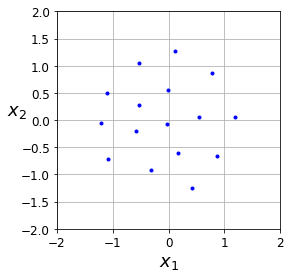

In [29]:
gan_encoder.trainable = False
gan_decoder.trainable = False

test_encoding(M,n)   


In [0]:
# test msg sequence for normal encoding
N_test = 500000
test_msg = np.random.randint(M, size=N_test)

In [0]:
#gan_encoder.summary()

Wasserstein GAN training

In [0]:
@tf.function
def w_train():
  gen_gradients, disc_gradients = compute_gradients()
  apply_gradients(gen_gradients, disc_gradients)

In [0]:
def compute_gradients():
  """ passes through the network and computes loss
  """
  x= tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)
  x =x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
  real_data = tf.concat(values=[real_channel(x,noise_std), x], axis=1)
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    disc_loss, gen_loss = compute_loss(real_data)
  gen_gradients = gen_tape.gradient(gen_loss, w_generator.trainable_variables)
  disc_gradients = disc_tape.gradient(disc_loss, w_discriminator.trainable_variables)

  #print("compute_gradients")

  return gen_gradients, disc_gradients

In [0]:
def compute_loss(real_data):
  """ passes through the network and computes loss
  """
        ### pass through network
        # generating noise from a uniform distribution
  ####Mein noise ist anders als hier
  gradient_penalty_weight = 0.1   #0.5
  x= tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)
  x_samp =x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
  #print(x_samp)
  # run noise through generator
  x_gen = tf.concat(values=[w_generator(x_samp),x_samp], axis=1)     # x_gen zu fake_data
  # discriminate x and x_gen
  logits_x = w_discriminator(real_data)
  logits_x_gen = w_discriminator(x_gen)

  # gradient penalty
  d_regularizer = gradient_penalty(real_data, x_gen)
        ### losses
  disc_loss = (tf.reduce_mean(logits_x) - tf.reduce_mean(logits_x_gen)+ d_regularizer * gradient_penalty_weight)

        # losses of fake with label "1"
  gen_loss = tf.reduce_mean(logits_x_gen)
  return disc_loss, gen_loss



def apply_gradients(gen_gradients, disc_gradients):
  w_gen_optimizer.apply_gradients(zip(gen_gradients, w_generator.trainable_variables))
  w_disc_optimizer.apply_gradients(zip(disc_gradients, w_discriminator.trainable_variables))

def gradient_penalty(x, x_gen):
  epsilon = tf.random.uniform([x.shape[0], 1, 1, 1], 0.0, 1.0)
  x_hat = epsilon * x + (1 - epsilon) * x_gen
  with tf.GradientTape() as t:
      t.watch(x_hat)
      d_hat = w_discriminator(x_hat)
  gradients = t.gradient(d_hat, x_hat)
  ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))
  d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
  #print("gradient_penalty")
  return d_regularizer



In [0]:
# optimizers
w_gen_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)#,beta_2 =0.1)  #RMSprop(0.0001) works as well
w_disc_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)#,beta_2 =0.1)  #(0.001)# train the model


In [0]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])
time_to_train_w_gan = 0

In [37]:
%%time
batch_size = 100
n_epochs = 2501   #2501
start = time.time()
for epoch in range(n_epochs):
  x= tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)
  x_samp =x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
  w_train()
    # test on holdout
  loss = []
  if epoch%500 == 0:
    real_c = tf.concat(values=[real_channel(x,noise_std), x], axis=1)
    fake_c = w_generator(x)
    #real_eval_data, fake_eval_data, inputs = get_evaluation_data()
    #test_eval(real_eval_data, fake_eval_data, inputs)
    tf.print(fake_c[0])
    #tf.print(disc_loss, gen_loss)
  real_data = tf.concat(values=[real_channel(x,noise_std), x], axis=1)  
  loss.append(compute_loss(real_data))
  losses.loc[len(losses)] = np.mean(loss, axis=0)
  if epoch%100 == 0:
    print(
       "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )  )
time_to_train_w_gan += time.time()-start
print()
tf.saved_model.save(w_generator,'/tmp/saved_model/')

[0.16060935 0.00944230705]
Epoch: 0 | disc_loss: 0.0766509398818016 | gen_loss: 0.49864423274993896
Epoch: 100 | disc_loss: 0.046292178332805634 | gen_loss: 0.4994540512561798
Epoch: 200 | disc_loss: 0.04191121459007263 | gen_loss: 0.4906556308269501
Epoch: 300 | disc_loss: 0.03165322169661522 | gen_loss: 0.4983702003955841
Epoch: 400 | disc_loss: 0.01042231172323227 | gen_loss: 0.5218945145606995
[-0.601687372 -0.156715766]
Epoch: 500 | disc_loss: -0.0313902422785759 | gen_loss: 0.5302461385726929
Epoch: 600 | disc_loss: 0.02352713793516159 | gen_loss: 0.45662766695022583
Epoch: 700 | disc_loss: 0.03307569772005081 | gen_loss: 0.46432504057884216
Epoch: 800 | disc_loss: -0.037785604596138 | gen_loss: 0.5276745557785034
Epoch: 900 | disc_loss: -0.09916341304779053 | gen_loss: 0.5586404204368591
[0.646110415 0.0420811251]
Epoch: 1000 | disc_loss: -0.07401721924543381 | gen_loss: 0.5244244933128357
Epoch: 1100 | disc_loss: -0.017699770629405975 | gen_loss: 0.4712587296962738
Epoch: 1200 

In [0]:
w_generator.trainable =False

In [39]:

%%time
w_gan_decoder = get_gan_decoder(M)
w_gan_encoder = get_gan_encoder(M)

gan_AE = tf.keras.models.Sequential([w_gan_encoder,w_generator,w_gan_decoder])
data, test_data = random_sample(10000000), random_sample(10000)
start = time.time()
gan_AE.compile(optimizer=tf.keras.optimizers.Nadam(lr=0.005),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = gan_AE.fit(data, data, batch_size=500,steps_per_epoch=400, epochs=10)
#time_to_train_gan += time.time()-start
time_to_train_w_gan += time.time()-start
tf.print ('Time for the training is {} sec,'.format(time_to_train_w_gan))
gan_AE.summary()  

Train on 10000000 samples
Epoch 1/10
  195500/10000000 [..............................] - ETA: 1:13 - loss: 7.3421e-04 - accuracy: 1.0000Time for the training is 89.9627013206482 sec,
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_11 (Sequential)   (None, None)              562       
_________________________________________________________________
model (Model)                (None, 2)                 1294      
_________________________________________________________________
sequential_10 (Sequential)   (None, 16)                320       
Total params: 2,176
Trainable params: 882
Non-trainable params: 1,294
_________________________________________________________________
CPU times: user 22.6 s, sys: 626 ms, total: 23.2 s
Wall time: 17.6 s


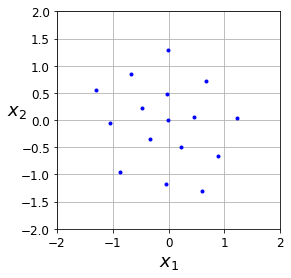

In [40]:
w_gan_encoder.trainable = False
w_gan_decoder.trainable = False

test_w_encoding(M=M,n=n)   


### Comparison

In [41]:
mi_bber_data = mi_Test_AE(test_msg)

Progress: 6 of 30 parts
Progress: 12 of 30 parts
Progress: 18 of 30 parts
Progress: 24 of 30 parts
Progress: 30 of 30 parts


In [42]:
gan_bber_data = gan_Test_AE(test_msg)

Progress: 6 of 30 parts
Progress: 12 of 30 parts
Progress: 18 of 30 parts
Progress: 24 of 30 parts
Progress: 30 of 30 parts


In [43]:
w_gan_bber_data = w_gan_Test_AE(test_msg)

Progress: 6 of 30 parts
Progress: 12 of 30 parts
Progress: 18 of 30 parts
Progress: 24 of 30 parts
Progress: 30 of 30 parts


time to train the AE Model with MI 63.32874536514282
time to train the AE Model with GAN 31.365469455718994
time to train the AE Model with WGAN, 89.9627013206482


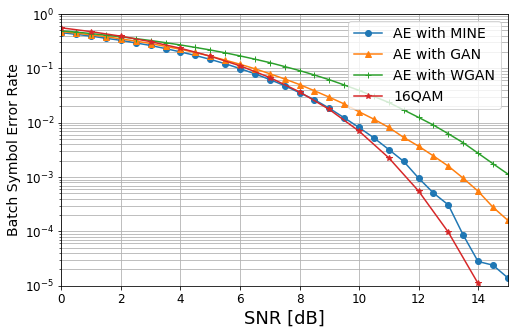

In [44]:
# Approximate 16 QAM Error
def SIXT_QAM_sim(ebno):
    return (3.0/2)*special.erfc(np.sqrt((4.0/10)*10.**(ebno/10)))

ebnodbs = np.linspace(0,15,16)
fig = plt.figure(figsize=(8, 5))
plt.semilogy(mi_bber_data[0], mi_bber_data[1], 'o-')
plt.semilogy(gan_bber_data[0], gan_bber_data[1], '^-')
plt.semilogy(w_gan_bber_data[0], w_gan_bber_data[1], '+-')
plt.semilogy(ebnodbs, SIXT_QAM_sim(ebnodbs), '*-');
plt.gca().set_ylim(1e-5, 1)
plt.gca().set_xlim(0, 15)
plt.ylabel("Batch Symbol Error Rate", fontsize=14, rotation=90)
plt.xlabel("SNR [dB]", fontsize=18)
plt.legend(['AE with MINE','AE with GAN','AE with WGAN', '16QAM'],
           prop={'size': 14}, loc='upper right');
plt.grid(True, which="both")

print('time to train the AE Model with MI',time_to_train_mi)
print('time to train the AE Model with GAN',time_to_train_gan)
tf.print ('time to train the AE Model with WGAN,',time_to_train_w_gan)

In [0]:
#generator.summary()

In [46]:
print(gan_bber_data[1])

[<tf.Tensor: id=1167997, shape=(), dtype=float32, numpy=0.474934>, <tf.Tensor: id=1168049, shape=(), dtype=float32, numpy=0.443874>, <tf.Tensor: id=1168101, shape=(), dtype=float32, numpy=0.413276>, <tf.Tensor: id=1168153, shape=(), dtype=float32, numpy=0.38206>, <tf.Tensor: id=1168205, shape=(), dtype=float32, numpy=0.34831>, <tf.Tensor: id=1168257, shape=(), dtype=float32, numpy=0.317248>, <tf.Tensor: id=1168309, shape=(), dtype=float32, numpy=0.286014>, <tf.Tensor: id=1168361, shape=(), dtype=float32, numpy=0.25317>, <tf.Tensor: id=1168413, shape=(), dtype=float32, numpy=0.224596>, <tf.Tensor: id=1168465, shape=(), dtype=float32, numpy=0.196254>, <tf.Tensor: id=1168517, shape=(), dtype=float32, numpy=0.167636>, <tf.Tensor: id=1168569, shape=(), dtype=float32, numpy=0.141908>, <tf.Tensor: id=1168621, shape=(), dtype=float32, numpy=0.119074>, <tf.Tensor: id=1168673, shape=(), dtype=float32, numpy=0.098306>, <tf.Tensor: id=1168725, shape=(), dtype=float32, numpy=0.079698>, <tf.Tensor: 